<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap05/5_1_Least_Squares_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 5.1: Least Squares Loss**

This notebook investigates the least squares loss and the equivalence of maximum likelihood and minimum negative log likelihood.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# Imports math library
import numpy as np
# Imports plotting library
import matplotlib.pyplot as plt
# Import math Library
import math

In [2]:
# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation):
  activation = preactivation.clip(0.0)
  return activation

# Define a shallow neural network
def shallow_nn(x, beta_0, omega_0, beta_1, omega_1):
    # Make sure that input data is (1 x n_data) array
    n_data = x.size
    x = np.reshape(x,(1,n_data))

    # This runs the network for ALL of the inputs, x at once so we can draw graph
    h1 = ReLU(np.matmul(beta_0,np.ones((1,n_data))) + np.matmul(omega_0,x))
    y = np.matmul(beta_1,np.ones((1,n_data))) + np.matmul(omega_1,h1)
    return y

In [3]:
# Get parameters for model -- we can call this function to easily reset them
def get_parameters():
  # And we'll create a network that approximately fits it
  beta_0 = np.zeros((3,1));  # formerly theta_x0
  omega_0 = np.zeros((3,1)); # formerly theta_x1
  beta_1 = np.zeros((1,1));  # formerly phi_0
  omega_1 = np.zeros((1,3)); # formerly phi_x

  beta_0[0,0] = 0.3; beta_0[1,0] = -1.0; beta_0[2,0] = -0.5
  omega_0[0,0] = -1.0; omega_0[1,0] = 1.8; omega_0[2,0] = 0.65
  beta_1[0,0] = 0.1;
  omega_1[0,0] = -2.0; omega_1[0,1] = -1.0; omega_1[0,2] = 7.0

  return beta_0, omega_0, beta_1, omega_1

In [4]:
# Utility function for plotting data
def plot_univariate_regression(x_model, y_model, x_data = None, y_data = None, sigma_model = None, title= None):
  # Make sure model data are 1D arrays
  x_model = np.squeeze(x_model)
  y_model = np.squeeze(y_model)

  fig, ax = plt.subplots()
  ax.plot(x_model,y_model)
  if sigma_model is not None:
    ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')
  ax.set_xlabel('Input, $x$'); ax.set_ylabel('Output, $y$')
  ax.set_xlim([0,1]);ax.set_ylim([-1,1])
  ax.set_aspect(0.5)
  if title is not None:
    ax.set_title(title)
  if x_data is not None:
    ax.plot(x_data, y_data, 'ko')
  plt.show()

# Univariate regression

We'll investigate a simple univariate regression situation with a single input $x$ and a single output $y$ as pictured in figures 5.4 and 5.5b.

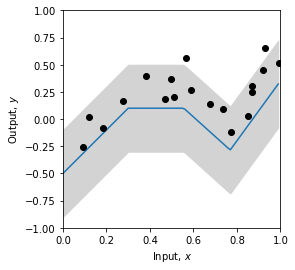

In [5]:
# Let's create some 1D training data
x_train = np.array([0.09291784,0.46809093,0.93089486,0.67612654,0.73441752,0.86847339,\
                   0.49873225,0.51083168,0.18343972,0.99380898,0.27840809,0.38028817,\
                   0.12055708,0.56715537,0.92005746,0.77072270,0.85278176,0.05315950,\
                   0.87168699,0.58858043])
y_train = np.array([-0.25934537,0.18195445,0.651270150,0.13921448,0.09366691,0.30567674,\
                    0.372291170,0.20716968,-0.08131792,0.51187806,0.16943738,0.3994327,\
                    0.019062570,0.55820410,0.452564960,-0.1183121,0.02957665,-1.24354444, \
                    0.248038840,0.26824970])

# Get parameters for the model
beta_0, omega_0, beta_1, omega_1 = get_parameters()
sigma = 0.2

# Define a range of input values
x_model = np.arange(0,1,0.01)
# Run the model to get values to plot and plot it.
y_model = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
plot_univariate_regression(x_model, y_model, x_train, y_train, sigma_model = sigma)


The blue line is the mean prediction of the model and the gray area represents plus/minus two standard deviations.  This model fits okay, but could be improved. Let's compute the loss.  We'll compute the  the least squares error, the likelihood, the negative log likelihood.

In [23]:
# Return probability under normal distribution
def normal_distribution(y, mu, sigma):
    # TODO-- write in the equation for the normal distribution
    # Equation 5.7 from the notes (you will need np.sqrt() and np.exp(), and math.pi)
    # Don't use the numpy version -- that's cheating!
    # Replace the line below
    prob = np.exp(-0.5*(y-mu)**2/sigma**2)/(sigma*np.sqrt(2*np.pi))

    return prob

In [24]:
# Let's double check we get the right answer before proceeding
print("Correct answer = %3.3f, Your answer = %3.3f"%(0.119,normal_distribution(1,-1,2.3)))

Correct answer = 0.119, Your answer = 0.119


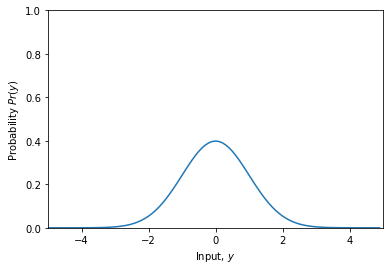

In [25]:
# Let's plot the Gaussian distribution.
y_gauss = np.arange(-5,5,0.1)
mu = 0; sigma = 1.0
gauss_prob = normal_distribution(y_gauss, mu, sigma)
fig, ax = plt.subplots()
ax.plot(y_gauss, gauss_prob)
ax.set_xlabel('Input, $y$'); ax.set_ylabel('Probability $Pr(y)$')
ax.set_xlim([-5,5]);ax.set_ylim([0,1.0])
plt.show()

# TODO
# 1. Predict what will happen if we change to mu=1 and leave sigma=1
# Now change the code above and see if you were correct.

# 2. Predict what will happen if we leave mu = 0 and change sigma to 2.0

# 3. Predict what will happen if we leave mu = 0 and change sigma to 0.5

Now let's compute the likelihood using this function

In [26]:
# Return the likelihood of all of the data under the model
def compute_likelihood(y_train, mu, sigma):
  # TODO -- compute the likelihood of the data -- the product of the normal probabilities for each data point
  # Top line of equation 5.3 in the notes
  # You will need np.prod() and the normal_distribution function you used above
  # Replace the line below
  likelihood = np.prod(normal_distribution(y_train,mu,sigma))

  return likelihood

In [27]:
# Let's test this for a homoscedastic (constant sigma) model
beta_0, omega_0, beta_1, omega_1 = get_parameters()
# Use our neural network to predict the mean of the Gaussian
mu_pred = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
# Set the standard deviation to something reasonable
sigma = 0.2
# Compute the likelihood
likelihood = compute_likelihood(y_train, mu_pred, sigma)
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f"%(0.000010624,likelihood))

Correct answer = 0.000010624, Your answer = 0.000010624


You can see that this gives a very small answer, even for this small 1D dataset, and with the model fitting quite well.  This is because it is the product of several probabilities, which are all quite small themselves.
This will get out of hand pretty quickly with real datasets -- the likelihood will get so small that we can't represent it with normal finite-precision math

This is why we use negative log likelihood

In [28]:
# Return the negative log likelihood of the data under the model
def compute_negative_log_likelihood(y_train, mu, sigma):
  # TODO -- compute the negative log likelihood of the data without using a product
  # In other words, compute minus one times the sum of the log probabilities
  # Equation 5.4 in the notes
  # You will need np.sum(), np.log()
  # Replace the line below
  nll = np.sum(-1*np.log(normal_distribution(y_train,mu,sigma)))

  return nll

In [29]:
# Let's test this for a homoscedastic (constant sigma) model
beta_0, omega_0, beta_1, omega_1 = get_parameters()
# Use our neural network to predict the mean of the Gaussian
mu_pred = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
# Set the standard deviation to something reasonable
sigma = 0.2
# Compute the negative log likelihood
nll = compute_negative_log_likelihood(y_train, mu_pred, sigma)
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f"%(11.452419564,nll))

Correct answer = 11.452419564, Your answer = 11.452419564


For good measure, let's compute the sum of squares as well

In [30]:
# Return the squared distance between the observed data (y_train) and the prediction of the model (y_pred)
def compute_sum_of_squares(y_train, y_pred):
  # TODO -- compute the sum of squared distances between the training data and the model prediction
  # Eqn 5.10 in the notes.  Make sure that you understand this, and ask questions if you don't
  # Replace the line below
  sum_of_squares = np.sum((y_train-y_pred)**2)

  return sum_of_squares

In [31]:
# Let's test this again
beta_0, omega_0, beta_1, omega_1 = get_parameters()
# Use our neural network to predict the mean of the Gaussian, which is out best prediction of y
y_pred = mu_pred = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
# Compute the sum of squares
sum_of_squares = compute_sum_of_squares(y_train, y_pred)
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f"%(2.020992572,sum_of_squares))

Correct answer = 2.020992572, Your answer = 2.020992572


Now let's investigate finding the maximum likelihood / minimum negative log likelihood / least squares solution.  For simplicity, we'll assume that all the parameters are correct except one and look at how the likelihood, negative log likelihood, and sum of squares change as we manipulate the last parameter.  We'll start with overall y offset, beta_1 (formerly phi_0)

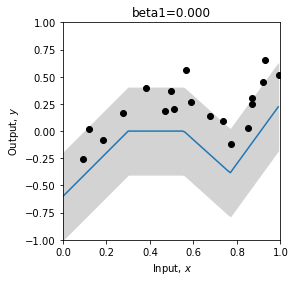

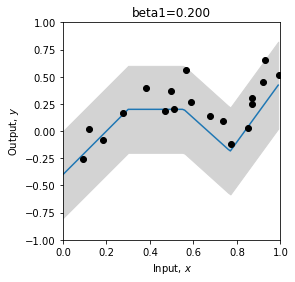

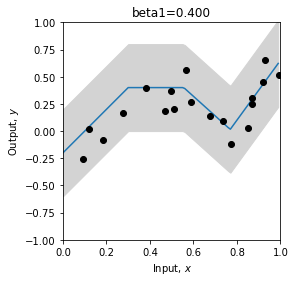

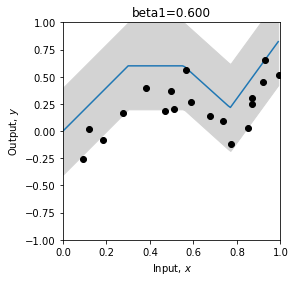

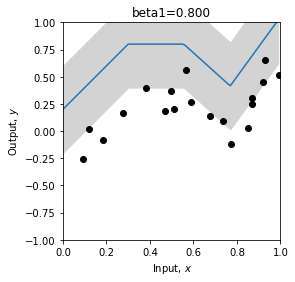

In [32]:
# Define a range of values for the parameter
beta_1_vals = np.arange(0,1.0,0.01)
# Create some arrays to store the likelihoods, negative log likelihoods and sum of squares
likelihoods = np.zeros_like(beta_1_vals)
nlls = np.zeros_like(beta_1_vals)
sum_squares = np.zeros_like(beta_1_vals)

# Initialise the parameters
beta_0, omega_0, beta_1, omega_1 = get_parameters()
sigma = 0.2
for count in range(len(beta_1_vals)):
  # Set the value for the parameter
  beta_1[0,0] = beta_1_vals[count]
  # Run the network with new parameters
  mu_pred = y_pred = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
  # Compute and store the three values
  likelihoods[count] = compute_likelihood(y_train, mu_pred, sigma)
  nlls[count] = compute_negative_log_likelihood(y_train, mu_pred, sigma)
  sum_squares[count] = compute_sum_of_squares(y_train, y_pred)
  # Draw the model for every 20th parameter setting
  if count % 20 == 0:
    # Run the model to get values to plot and plot it.
    y_model = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
    plot_univariate_regression(x_model, y_model, x_train, y_train, sigma_model = sigma, title="beta1=%3.3f"%(beta_1[0,0]))


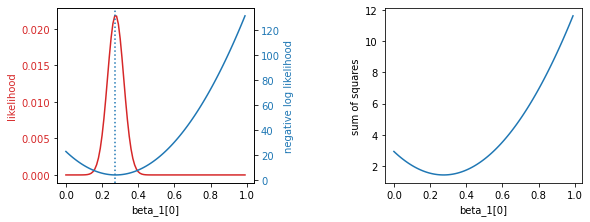

In [33]:
# Now let's plot the likelihood, negative log likelihood, and least squares as a function of the value of the offset beta1
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10.5, 5.5)
fig.tight_layout(pad=10.0)
likelihood_color = 'tab:red'
nll_color = 'tab:blue'

ax[0].set_xlabel('beta_1[0]')
ax[0].set_ylabel('likelihood', color = likelihood_color)
ax[0].plot(beta_1_vals, likelihoods, color = likelihood_color)
ax[0].tick_params(axis='y', labelcolor=likelihood_color)

ax00 = ax[0].twinx()
ax00.plot(beta_1_vals, nlls, color = nll_color)
ax00.set_ylabel('negative log likelihood', color = nll_color)
ax00.tick_params(axis='y', labelcolor = nll_color)

plt.axvline(x = beta_1_vals[np.argmax(likelihoods)], linestyle='dotted')

ax[1].plot(beta_1_vals, sum_squares); ax[1].set_xlabel('beta_1[0]'); ax[1].set_ylabel('sum of squares')
plt.show()

Maximum likelihood = 0.000, at beta_1=0.000
Minimum negative log likelihood = 0.000, at beta_1=0.000
Least squares = 0.000, at beta_1=0.000


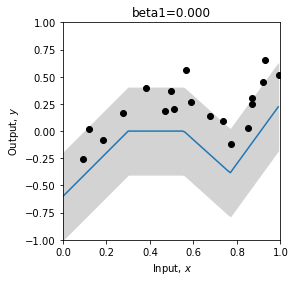

In [17]:
# Hopefully, you can see that the maximum of the likelihood fn is at the same position as the minimum negative log likelihood
# and the least squares solutions
# Let's check that:
print("Maximum likelihood = %3.3f, at beta_1=%3.3f"%( (likelihoods[np.argmax(likelihoods)],beta_1_vals[np.argmax(likelihoods)])))
print("Minimum negative log likelihood = %3.3f, at beta_1=%3.3f"%( (nlls[np.argmin(nlls)],beta_1_vals[np.argmin(nlls)])))
print("Least squares = %3.3f, at beta_1=%3.3f"%( (sum_squares[np.argmin(sum_squares)],beta_1_vals[np.argmin(sum_squares)])))

# Plot the best model
beta_1[0,0] = beta_1_vals[np.argmin(sum_squares)]
y_model = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
plot_univariate_regression(x_model, y_model, x_train, y_train, sigma_model = sigma, title="beta1=%3.3f"%(beta_1[0,0]))

They all give the same answer. But you can see from the three plots above that the likelihood is very small unless the parameters are almost correct.  So in practice, we would work with the negative log likelihood or the least squares.<br>

Let's do the same thing with the standard deviation parameter of our network.  This is not an output of the network (unless we choose to make that the case), but it still affects the likelihood.



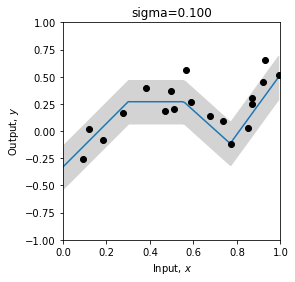

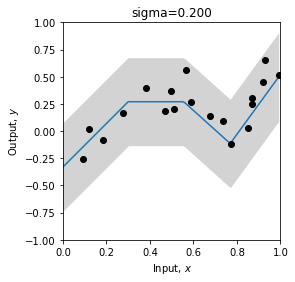

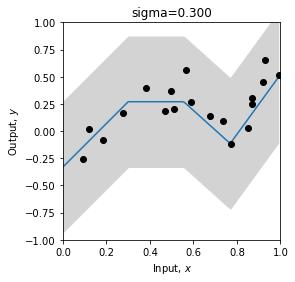

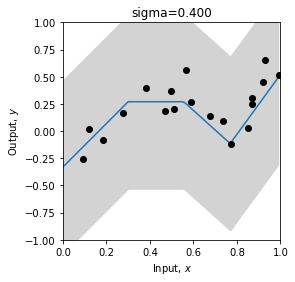

In [34]:
# Define a range of values for the parameter
sigma_vals = np.arange(0.1,0.5,0.005)
# Create some arrays to store the likelihoods, negative log likelihoods and sum of squares
likelihoods = np.zeros_like(sigma_vals)
nlls = np.zeros_like(sigma_vals)
sum_squares = np.zeros_like(sigma_vals)

# Initialise the parameters
beta_0, omega_0, beta_1, omega_1 = get_parameters()
# Might as well set to the best offset
beta_1[0,0] = 0.27
for count in range(len(sigma_vals)):
  # Set the value for the parameter
  sigma = sigma_vals[count]
  # Run the network with new parameters
  mu_pred = y_pred = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
  # Compute and store the three values
  likelihoods[count] = compute_likelihood(y_train, mu_pred, sigma)
  nlls[count] = compute_negative_log_likelihood(y_train, mu_pred, sigma)
  sum_squares[count] = compute_sum_of_squares(y_train, y_pred)
  # Draw the model for every 20th parameter setting
  if count % 20 == 0:
    # Run the model to get values to plot and plot it.
    y_model = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
    plot_univariate_regression(x_model, y_model, x_train, y_train, sigma_model=sigma, title="sigma=%3.3f"%(sigma))

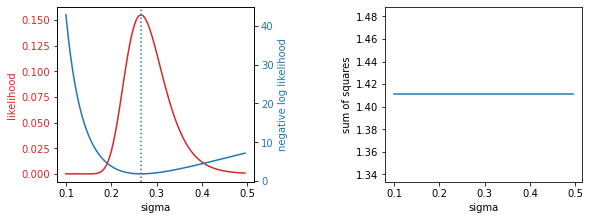

In [35]:
# Now let's plot the likelihood, negative log likelihood, and least squares as a function of the value of the standard deviation sigma
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10.5, 5.5)
fig.tight_layout(pad=10.0)
likelihood_color = 'tab:red'
nll_color = 'tab:blue'


ax[0].set_xlabel('sigma')
ax[0].set_ylabel('likelihood', color = likelihood_color)
ax[0].plot(sigma_vals, likelihoods, color = likelihood_color)
ax[0].tick_params(axis='y', labelcolor=likelihood_color)

ax00 = ax[0].twinx()
ax00.plot(sigma_vals, nlls, color = nll_color)
ax00.set_ylabel('negative log likelihood', color = nll_color)
ax00.tick_params(axis='y', labelcolor = nll_color)

plt.axvline(x = sigma_vals[np.argmax(likelihoods)], linestyle='dotted')

ax[1].plot(sigma_vals, sum_squares); ax[1].set_xlabel('sigma'); ax[1].set_ylabel('sum of squares')
plt.show()

Maximum likelihood = 0.155, at sigma=0.265
Minimum negative log likelihood = 1.864, at sigma=0.265


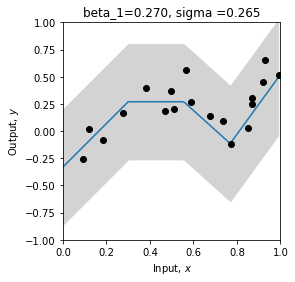

In [36]:
# Hopefully, you can see that the maximum of the likelihood fn is at the same position as the minimum negative log likelihood
# The least squares solution does not depend on sigma, so it's just flat -- no use here.
# Let's check that:
print("Maximum likelihood = %3.3f, at sigma=%3.3f"%( (likelihoods[np.argmax(likelihoods)],sigma_vals[np.argmax(likelihoods)])))
print("Minimum negative log likelihood = %3.3f, at sigma=%3.3f"%( (nlls[np.argmin(nlls)],sigma_vals[np.argmin(nlls)])))
# Plot the best model
sigma= sigma_vals[np.argmin(nlls)]
y_model = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
plot_univariate_regression(x_model, y_model, x_train, y_train, sigma_model = sigma, title="beta_1=%3.3f, sigma =%3.3f"%(beta_1[0,0],sigma))

Obviously, to fit the full neural model we would vary all of the 10 parameters of the network in $\boldsymbol\beta_{0},\boldsymbol\Omega_{0},\boldsymbol\beta_{1},\boldsymbol\Omega_{1}$ (and maybe $\sigma$) until we find the combination that have the maximum likelihood / minimum negative log likelihood / least squares.<br><br>

Here we just varied one at a time as it is easier to see what is going on.  This is known as **coordinate descent**.
